<a href="https://colab.research.google.com/github/haosulab/SAPIEN-tutorial/blob/master/2_create_actors.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Some core features of SAPIEN are not available on Colab, including the interactive viewer and ray-tracing functionalities. You need to run SAPIEN locally for full features. A more comprehensive tutorial including features that are only available to local environment can be found at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/2.2/index.html).

# Tutorial 2: Create Actors

SAPIEN simulates rigid body dynamics. In SAPIEN, **actor** is an alias of rigid body.

In this tutorial, you will learn the following:

- Create `Actor` using primitives (box, sphere, capsule)
- Use `Pose` to set the pose of an actor

## Preparation

**Note: you need GPU runtime to run the notebook.**

In [1]:
%pip install sapien
import sapien.core as sapien
import numpy as np
from PIL import Image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Before we start, let's set up the simulation engine and renderer, and add the ground to our scene.

In [2]:
# Set up simulation engine and renderer
engine = sapien.Engine()
renderer = sapien.SapienRenderer()
engine.set_renderer(renderer)

scene = engine.create_scene()
scene.set_timestep(1 / 100.0)

scene.add_ground(altitude=0)  # The ground is in fact a special actor.

Actor(name="ground", id="1")

## Create an actor by a single primitive

The primitives supported by SAPIEN include box, sphere and capsule. Let's see an example about how to create a box.

In [3]:
def create_box(
        scene: sapien.Scene,
        pose: sapien.Pose,
        half_size,
        color=None,
        name='',
) -> sapien.Actor:
    """Create a box.

    Args:
        scene: sapien.Scene to create a box.
        pose: 6D pose of the box.
        half_size: [3], half size along x, y, z axes.
        color: [3] or [4], rgb or rgba
        name: name of the actor.

    Returns:
        sapien.Actor
    """
    half_size = np.array(half_size)
    builder: sapien.ActorBuilder = scene.create_actor_builder()
    builder.add_box_collision(half_size=half_size)  # Add collision shape
    builder.add_box_visual(half_size=half_size, color=color)  # Add visual shape
    box: sapien.Actor = builder.build(name=name)
    # Or you can set_name after building the actor
    # box.set_name(name)
    box.set_pose(pose)
    return box

`Actor` (or rigid body) is created through `ActorBuilder` in SAPIEN. An actor consists of both collision shapes (used for physical simulation) and visual shapes (used for rendering). You can call `add_box_collision` and `add_box_visual` to add collision and visual shapes of an box respectively.

> Note: Collision shapes do not necessarily correspond to visual shapes. For example, you might have a simple collision shape for fast simulation, but a complicated visual shape for realistic rendering.

Then, you might create a box as follows:

In [4]:
box = create_box(
    scene,
    sapien.Pose(p=[0, 0, 1.0 + 0.05]),
    half_size=[0.05, 0.05, 0.05],
    color=[1., 0., 0.],
    name='box',
)

> `sapien.Pose` takes two parameters, `p` and `q`, to construct. The `p` parameter is a three-dimensional translation vector that specifies that position of the actor, and `q` is a four-dimensional quarternion that specifies the orientation of the actor.

Similarly, we can create a sphere and a capsule in our scene.

In [5]:
def create_sphere(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        color=None,
        name='',
) -> sapien.Actor:
    """Create a sphere. See create_box."""
    builder = scene.create_actor_builder()
    builder.add_sphere_collision(radius=radius)
    builder.add_sphere_visual(radius=radius, color=color)
    sphere = builder.build(name=name)
    sphere.set_pose(pose)
    return sphere


def create_capsule(
        scene: sapien.Scene,
        pose: sapien.Pose,
        radius,
        half_length,
        color=None,
        name='',
) -> sapien.Actor:
    """Create a capsule (x-axis <-> half_length). See create_box."""
    builder = scene.create_actor_builder()
    builder.add_capsule_collision(radius=radius, half_length=half_length)
    builder.add_capsule_visual(radius=radius, half_length=half_length, color=color)
    capsule = builder.build(name=name)
    capsule.set_pose(pose)
    return capsule

In [6]:
sphere = create_sphere(
    scene,
    sapien.Pose(p=[0, -0.2, 1.0 + 0.05]),
    radius=0.05,
    color=[0., 1., 0.],
    name='sphere',
)

capsule = create_capsule(
    scene,
    sapien.Pose(p=[0, 0.2, 1.0 + 0.05]),
    radius=0.05,
    half_length=0.05,
    color=[0., 0., 1.],
    name='capsule',
)

## Create an actor by multiple primitives

Next, we show an example to create an actor (table) by multiple boxes (a tabletop with four legs).

In [7]:
def create_table(
        scene: sapien.Scene,
        pose: sapien.Pose,
        size,
        height,
        thickness=0.1,
        color=(0.8, 0.6, 0.4),
        name='table',
) -> sapien.Actor:
    """Create a table (a collection of collision and visual shapes)."""
    builder = scene.create_actor_builder()
    
    # Tabletop
    tabletop_pose = sapien.Pose([0., 0., -thickness / 2])  # Make the top surface's z equal to 0
    tabletop_half_size = [size / 2, size / 2, thickness / 2]
    builder.add_box_collision(pose=tabletop_pose, half_size=tabletop_half_size)
    builder.add_box_visual(pose=tabletop_pose, half_size=tabletop_half_size, color=color)
    
    # Table legs (x4)
    for i in [-1, 1]:
        for j in [-1, 1]:
            x = i * (size - thickness) / 2
            y = j * (size - thickness) / 2
            table_leg_pose = sapien.Pose([x, y, -height / 2])
            table_leg_half_size = [thickness / 2, thickness / 2, height / 2]
            builder.add_box_collision(pose=table_leg_pose, half_size=table_leg_half_size)
            builder.add_box_visual(pose=table_leg_pose, half_size=table_leg_half_size, color=color)

    table = builder.build(name=name)
    table.set_pose(pose)
    return table

In [8]:
table = create_table(
    scene,
    sapien.Pose(p=[0, 0, 1.0]),
    size=1.0,
    height=1.0,
)

We can call `add_box_collision(pose=Pose(...), ...)` to set the pose of a collision shape in the actor frame. Similarly, we can call `add_box_visual(pose=Pose(...), ...)` for a visual shape. Note that `table.set_pose(pose)` sets the pose of the actor in the **world frame**.

## Visualization

Let's visualize the scene as we did before:

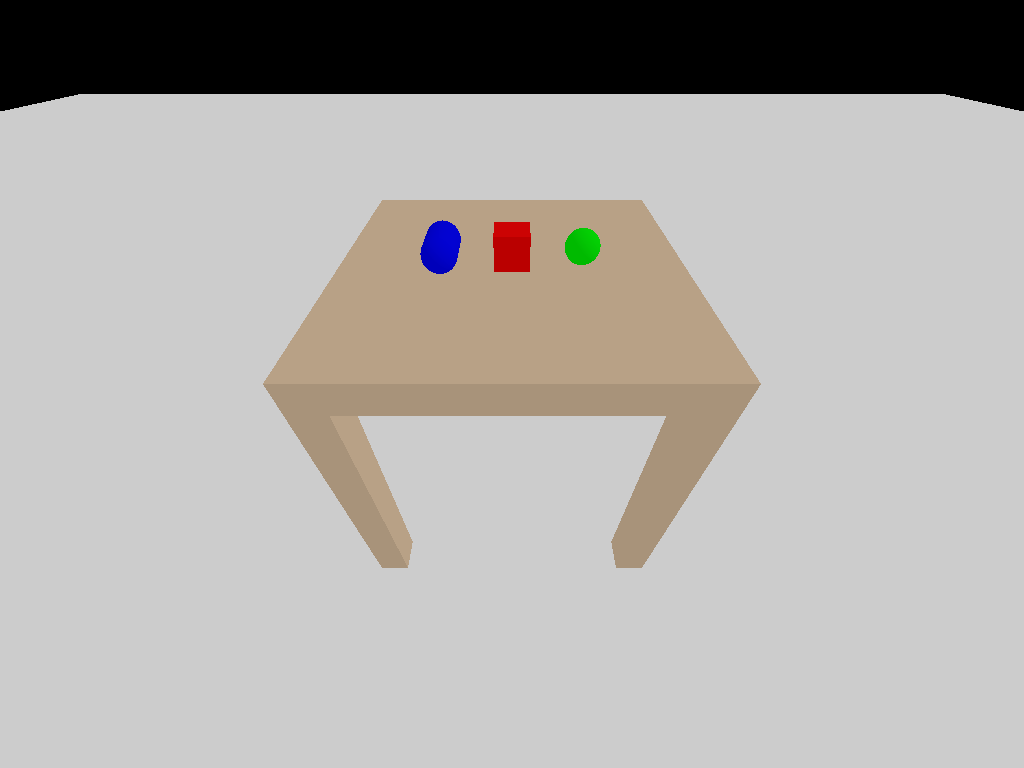

In [9]:
scene.set_ambient_light([0.5, 0.5, 0.5])
scene.add_directional_light([0, 1, -1], [0.5, 0.5, 0.5])

camera = scene.add_camera(name='camera', width=1024, height=768, fovy=1.57, near=0.1, far=100)
camera.set_pose(sapien.Pose([-1.04541, 0, 1.54541], [0.92388, 0, 0.382683, 0]))

scene.step()
scene.update_render()
camera.take_picture()
rgba = camera.get_color_rgba()

rgb = rgba[..., :3]
Image.fromarray((rgb*255).astype(np.uint8))

## Remove an actor

After an actor is built with `actor = builder.build()`, You can call `scene.remove_actor(actor)` to remove it. Using a removed actor will result in undefined behavior (usually a crash).

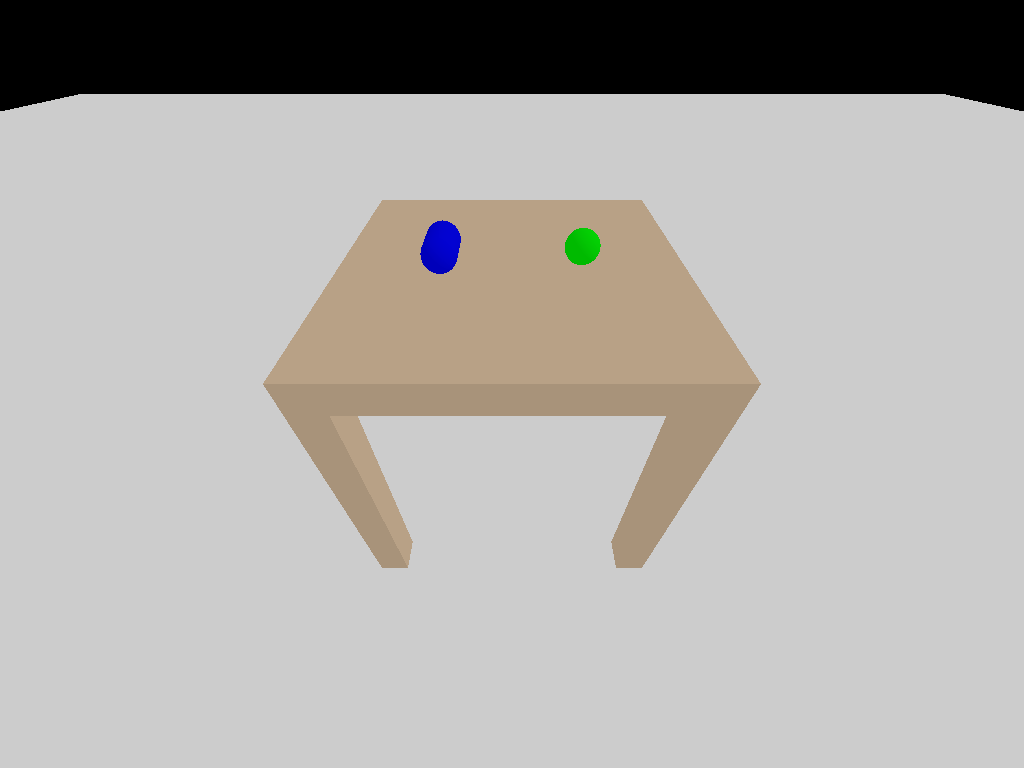

In [11]:
scene.remove_actor(box) # Remove the box

scene.step()
scene.update_render()
camera.take_picture()
rgba = camera.get_color_rgba()

rgb = rgba[..., :3]
Image.fromarray((rgb*255).astype(np.uint8))

## Create an actor by a mesh file

In SAPIEN, you can also create an actor from the mesh file. For more information, please refer to the comprehensive tutorial linked at the top of the notebook.